In [1]:
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import easygems.healpix as egh
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import Normalize
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import numpy as np
from functools import partial

# **ERA5 mtpr**

In [2]:
# List of NetCDF files
file_list = [
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200401-20200430.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200501-20200531.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200601-20200630.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200701-20200731.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200801-20200831.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200901-20200930.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201001-20201031.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201101-20201130.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201201-20201231.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2021/mtpr_era5_oper_sfc_20210101-20210131.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2021/mtpr_era5_oper_sfc_20210201-20210228.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2021/mtpr_era5_oper_sfc_20210301-20210331.nc"
]

# Open and concatenate along 'time' dimension for a specific variable
# Replace 'your_variable_name' with the actual variable name
# ds = xr.open_mfdataset(
#     file_list,
#     combine='by_coords'  # or 'nested' with concat_dim='time' if not auto-aligning
# )
ds = xr.open_mfdataset(
    file_list,
    combine='by_coords',
    chunks={'time': 1000}  # or a specific value like 1000, depending on your dataset
)
# Access the desired variable (optional)
pr = ds['mtpr']
hourly_avg = pr.groupby('time.hour').mean(dim='time')

pr_max = xr.Dataset({
    "max_hour": hourly_avg.idxmax(dim='hour'),
    "max_value": hourly_avg.max(dim='hour'),
    "min_hour": hourly_avg.idxmin(dim='hour'),
    "min_value": hourly_avg.min(dim='hour'),
})

# Add difference between max and min values
pr_max["value_range"] = pr_max["max_value"] - pr_max["min_value"]


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(


In [4]:
pr_max.to_netcdf("/scratch/nf33/hl1052/hackthon2025_pr/era5_prmax.nc")

# **UM pr**

In [ ]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
pr_selected = ds_1.pr.sel(time=slice('2020-04-01', '2021-03-31'))
# Group by the hour of the day and compute the mean
hourly_avg = pr_selected.groupby('time.hour').mean(dim='time')

pr_max = xr.Dataset({
    "max_hour": hourly_avg.idxmax(dim='hour'),
    "max_value": hourly_avg.max(dim='hour'),
    "min_hour": hourly_avg.idxmin(dim='hour'),
    "min_value": hourly_avg.min(dim='hour'),
})

# Add difference between max and min values
pr_max["value_range"] = pr_max["max_value"] - pr_max["min_value"]
# ds_dict_diff = {3:pr_max.value_range, 4:pr_max_2.value_range}
pr_max.to_netcdf("/scratch/nf33/hl1052/hackthon2025_pr/um_prmax.nc")

# **plot**

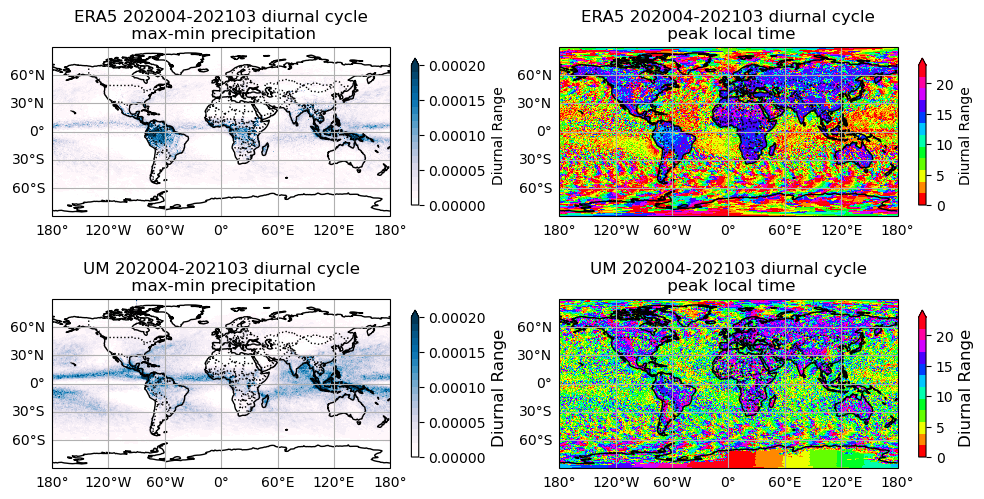

In [20]:
ds = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/era5_prmax.nc")
da_max = ds["value_range"]
base_cmap = plt.get_cmap('PuBu')

# Get the colors from the base colormap
colors = base_cmap(np.linspace(0, 1, 19)) # Prepend white to the list of colors
new_colors = np.vstack(([1, 1, 1, 1], colors))  # white with alpha=1
new_cmap = mcolors.ListedColormap(new_colors)


plt.figure(figsize=(12, 6))
proj = ccrs.PlateCarree(central_longitude=0.0)
# ax = plt.axes(projection=proj)

ax=plt.subplot(2,2,1,projection=proj)
# Plot the data (transform tells Cartopy what the data's native projection is)
da_max.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=new_cmap, vmin=0, vmax=0.0002,
    cbar_kwargs={'label': 'Diurnal Range',
    'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 202004-202103 diurnal cycle\n max-min precipitation')


ax=plt.subplot(2,2,2,projection=proj)
cmap_2 = plt.get_cmap('hsv', 12)

# Compute the time offset in hours based on longitude
lon = ds["max_hour"].longitude
time_offset = lon / 15.0  # degrees per hour

# Broadcast time offset to the shape of max_hour
offset_2d = xr.broadcast(time_offset, ds["max_hour"])[0]

# Convert UTC to local time
local_hour = (ds["max_hour"] + offset_2d) % 24
local_hour.name = "local_hour"


# Plot the data (transform tells Cartopy what the data's native projection is)
local_hour.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=cmap_2, vmin=0, vmax=23,
    cbar_kwargs={'label': 'Diurnal Range', 'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 202004-202103 diurnal cycle\n peak local time')



ds_3 = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/um_prmax.nc")
da_max_3 = ds_3["value_range"]
ax=plt.subplot(2,2,3,projection=proj)
ax.set_global()
# ax = egh.create_geoaxis(add_coastlines=True,projection=proj)
im = egh.healpix_show(da_max_3.values, ax=ax, cmap=new_cmap, vmin=0, vmax=0.0002, add_coastlines=True)
fig=ax.get_figure()
cbar = fig.colorbar(im, orientation='vertical', shrink=0.7, extend='max')
cbar.set_label('Diurnal Range', fontsize=12)
# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('UM 202004-202103 diurnal cycle\n max-min precipitation')


ax=plt.subplot(2,2,4,projection=proj)
ax.set_global()

ds_3 = ds_3.pipe(partial(egh.attach_coords))
# Compute the time offset in hours based on longitude
lon_3 = ds_3["max_hour"].lon
time_offset_3 = lon_3 / 15.0  # degrees per hour

# Broadcast time offset to the shape of max_hour
offset_2d_3 = xr.broadcast(time_offset_3, ds_3["max_hour"])[0]

# Convert UTC to local time
local_hour_3 = (ds_3["max_hour"] + offset_2d_3) % 24
local_hour_3.name = "local_hour"


# ax = egh.create_geoaxis(fig=ax, add_coastlines=True,projection=proj)
im_2 = egh.healpix_show(local_hour_3.values, ax=ax, cmap=cmap_2, vmin=0, vmax=23, add_coastlines=True)
fig=ax.get_figure()
cbar = fig.colorbar(im_2, orientation='vertical', shrink=0.7, extend='max')
cbar.set_label('Diurnal Range', fontsize=12)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('UM 202004-202103 diurnal cycle\n peak local time') # local

plt.show()

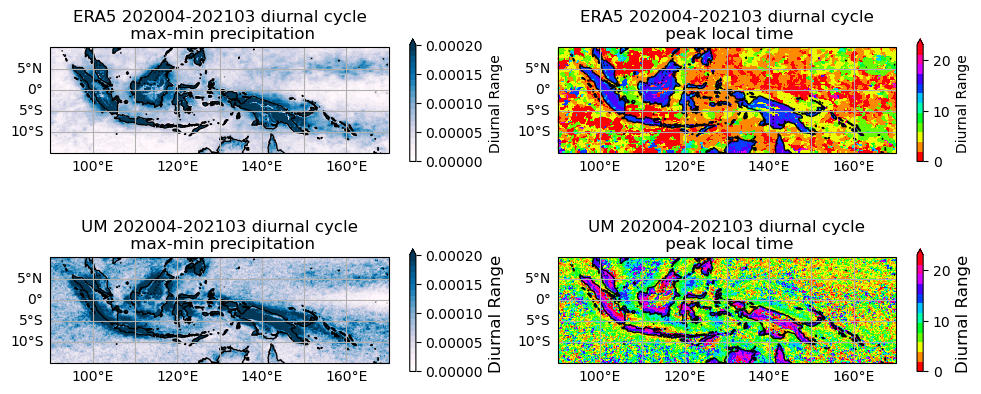

In [19]:
ds = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/era5_prmax.nc")
da_max = ds["value_range"]
base_cmap = plt.get_cmap('PuBu')

# Get the colors from the base colormap
colors = base_cmap(np.linspace(0, 1, 19)) # Prepend white to the list of colors
new_colors = np.vstack(([1, 1, 1, 1], colors))  # white with alpha=1
new_cmap = mcolors.ListedColormap(new_colors)


plt.figure(figsize=(12, 5))
proj = ccrs.PlateCarree(central_longitude=0.0)
# ax = plt.axes(projection=proj)

ax=plt.subplot(2,2,1,projection=proj)
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())
# Plot the data (transform tells Cartopy what the data's native projection is)
da_max.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=new_cmap, vmin=0, vmax=0.0002,
    cbar_kwargs={'label': 'Diurnal Range',
    'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 202004-202103 diurnal cycle\n max-min precipitation')


ax=plt.subplot(2,2,2,projection=proj)
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())
cmap_2 = plt.get_cmap('hsv', 12)

# Compute the time offset in hours based on longitude
lon = ds["max_hour"].longitude
time_offset = lon / 15.0  # degrees per hour

# Broadcast time offset to the shape of max_hour
offset_2d = xr.broadcast(time_offset, ds["max_hour"])[0]

# Convert UTC to local time
local_hour = (ds["max_hour"] + offset_2d) % 24
local_hour.name = "local_hour"


# Plot the data (transform tells Cartopy what the data's native projection is)
local_hour.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=cmap_2, vmin=0, vmax=23,
    cbar_kwargs={'label': 'Diurnal Range', 'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 202004-202103 diurnal cycle\n peak local time')



ds_3 = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/um_prmax.nc")
da_max_3 = ds_3["value_range"]
ax=plt.subplot(2,2,3,projection=proj)

ax.set_global()
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())
# ax = egh.create_geoaxis(add_coastlines=True,projection=proj)
im = egh.healpix_show(da_max_3.values, ax=ax, cmap=new_cmap, vmin=0, vmax=0.0002, add_coastlines=True)
fig=ax.get_figure()
cbar = fig.colorbar(im, orientation='vertical', shrink=0.7, extend='max')
cbar.set_label('Diurnal Range', fontsize=12)
# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('UM 202004-202103 diurnal cycle\n max-min precipitation')


ax=plt.subplot(2,2,4,projection=proj)
ax.set_global()
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())

ds_3 = ds_3.pipe(partial(egh.attach_coords))
# Compute the time offset in hours based on longitude
lon_3 = ds_3["max_hour"].lon
time_offset_3 = lon_3 / 15.0  # degrees per hour

# Broadcast time offset to the shape of max_hour
offset_2d_3 = xr.broadcast(time_offset_3, ds_3["max_hour"])[0]

# Convert UTC to local time
local_hour_3 = (ds_3["max_hour"] + offset_2d_3) % 24
local_hour_3.name = "local_hour"


# ax = egh.create_geoaxis(fig=ax, add_coastlines=True,projection=proj)
im_2 = egh.healpix_show(local_hour_3.values, ax=ax, cmap=cmap_2, vmin=0, vmax=23, add_coastlines=True)
fig=ax.get_figure()
cbar = fig.colorbar(im_2, orientation='vertical', shrink=0.7, extend='max')
cbar.set_label('Diurnal Range', fontsize=12)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('UM 202004-202103 diurnal cycle\n peak local time') # local

plt.show()

# **MC land/sea composite cycle**

In [3]:
file_list = [
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200401-20200430.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200501-20200531.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200601-20200630.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200701-20200731.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200801-20200831.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200901-20200930.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201001-20201031.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201101-20201130.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201201-20201231.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2021/mtpr_era5_oper_sfc_20210101-20210131.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2021/mtpr_era5_oper_sfc_20210201-20210228.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2021/mtpr_era5_oper_sfc_20210301-20210331.nc"
]

# Open and concatenate along 'time' dimension for a specific variable
# Replace 'your_variable_name' with the actual variable name
# ds = xr.open_mfdataset(
#     file_list,
#     combine='by_coords'  # or 'nested' with concat_dim='time' if not auto-aligning
# )
ds = xr.open_mfdataset(
    file_list,
    combine='by_coords',
    chunks={'time': 1000}  # or a specific value like 1000, depending on your dataset
)
# Access the desired variable (optional)
pr = ds['mtpr']

# 2. Spatial selection for bounding box [lon_min, lon_max, lat_min, lat_max]
lon_min, lon_max = 90, 170
lat_min, lat_max = -15, 10

# Assuming 'lat' and 'lon' are coordinates associated with 'cell'
lat = ds.latitude
lon = ds.longitude

# Create spatial mask
spatial_mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)

# Apply spatial mask
pr_selected = pr.where(spatial_mask, drop=False)

# Group by the hour of the day and compute the mean
hourly_avg = pr_selected.groupby('time.hour').mean(dim='time')
data = hourly_avg


ds_mask = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/2020/lsm_era5_oper_sfc_20200801-20200831.nc")

lsm = ds_mask['lsm'].isel(time=0)

# Create land and ocean masks
land_mask = lsm.where(lsm == 1)
ocean_mask = lsm.where(lsm == 0)


# 3. Apply masks to your data
land_data  = data.where(land_mask)   # keeps data over land, NaN over ocean
ocean_data = data.where(ocean_mask)  # keeps data over ocean, NaN over land

land_mean = land_data.mean(dim=["latitude", "longitude"])
ocean_mean = ocean_data.mean(dim=["latitude", "longitude"])

# Combine into one Dataset
combined = xr.Dataset({
    "land_mean": land_mean,
    "ocean_mean": ocean_mean
})

# Save to NetCDF
combined.to_netcdf("/scratch/nf33/hl1052/hackthon2025_pr/era5_land_ocean_mean.nc")


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


In [ ]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
ds_1 = ds_1.pipe(partial(egh.attach_coords))
pr_selected = ds_1.pr.sel(time=slice('2020-04-01', '2021-03-31'))

# 2. Spatial selection for bounding box [lon_min, lon_max, lat_min, lat_max]
lon_min, lon_max = 90, 170
lat_min, lat_max = -15, 10

# Assuming 'lat' and 'lon' are coordinates associated with 'cell'
lat = ds_1.lat
lon = ds_1.lon

# Create spatial mask
spatial_mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)

# Apply spatial mask
pr_selected = pr_selected.where(spatial_mask, drop=False)



# Group by the hour of the day and compute the mean
hourly_avg = pr_selected.groupby('time.hour').mean(dim='time')
data = hourly_avg


data_sftlf = "/g/data/nf33/hk25_AusNode_coastal/sftlf_um_z8.zarr"
ds_1 = xr.open_zarr(data_sftlf)
sftlf = ds_1.sftlf    # same lon/lat grid

land_mask = sftlf > 0
ocean_mask = ~land_mask

# 3. Apply masks to your data
land_data  = data.where(land_mask)   # keeps data over land, NaN over ocean
ocean_data = data.where(ocean_mask)  # keeps data over ocean, NaN over land

land_mean = land_data.mean(dim="cell")
ocean_mean = ocean_data.mean(dim="cell")

# Combine into one Dataset
combined = xr.Dataset({
    "land_mean": land_mean,
    "ocean_mean": ocean_mean
})

# Save to NetCDF
combined.to_netcdf("/scratch/nf33/hl1052/hackthon2025_pr/um_land_ocean_mean.nc")

In [8]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
ds_1 = ds_1.pipe(partial(egh.attach_coords))
pr_selected = ds_1.pr.sel(time=slice('2020-04-01', '2021-03-31'))

# 2. Spatial selection for bounding box [lon_min, lon_max, lat_min, lat_max]
lon_min, lon_max = 90, 170
lat_min, lat_max = -15, 10

# Assuming 'lat' and 'lon' are coordinates associated with 'cell'
lat = ds_1.lat
lon = ds_1.lon

# Create spatial mask
spatial_mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)

# Apply spatial mask
pr_selected = pr_selected.where(spatial_mask, drop=False)



# Group by the hour of the day and compute the mean
hourly_avg = pr_selected.groupby('time.hour').mean(dim='time')
data = hourly_avg


data_sftlf = "/g/data/nf33/hk25_AusNode_coastal/sftlf_um_z8.zarr"
ds_1 = xr.open_zarr(data_sftlf)
sftlf = ds_1.sftlf    # same lon/lat grid

land_mask = sftlf > 0
ocean_mask = ~land_mask

# 3. Apply masks to your data
land_data  = data.where(land_mask)   # keeps data over land, NaN over ocean
ocean_data = data.where(ocean_mask)  # keeps data over ocean, NaN over land

land_mean = land_data.mean(dim="cell")
ocean_mean = ocean_data.mean(dim="cell")

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: bitmask sparsity=0.666058394160584, merge=False, choosing 'map-reduce'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


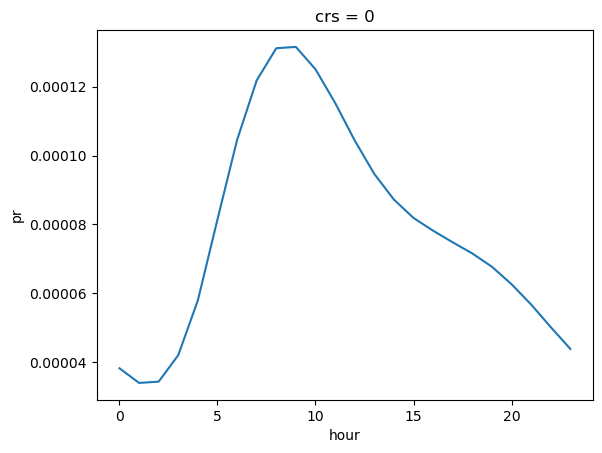

In [9]:
land_mean.plot()

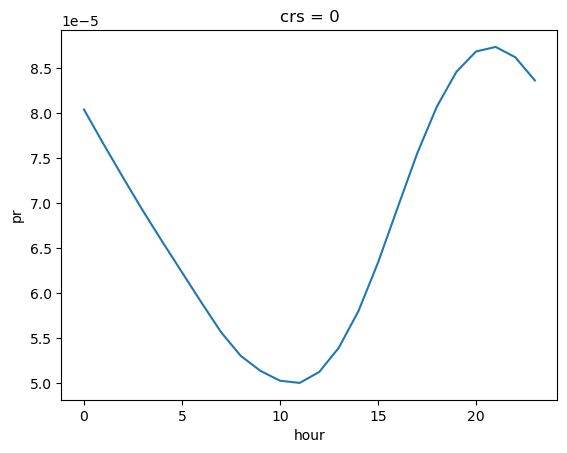

In [10]:
ocean_mean.plot()

In [ ]:
data

In [6]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
ds_1 = ds_1.pipe(partial(egh.attach_coords))
# Compute the time offset in hours based on longitude
lon = ds_1.lon

In [7]:
lon

<xarray.DataArray 'lon' (cell: 786432)> Size: 6MB
array([ 45.        ,  45.17578125,  44.82421875, ..., 315.17578125,
       314.82421875, 315.        ])
Coordinates:
    crs      int64 8B 0
  * cell     (cell) int64 6MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    lat      (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.2984 -0.1492
    lon      (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Attributes:
    units:          degree_east
    standard_name:  longitude
    axis:           X

In [2]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
pr_selected = ds_1.pr.sel(time=slice('2020-04-01', '2021-03-31'))
# Group by the hour of the day and compute the mean
hourly_avg = pr_selected.groupby('time.hour').mean(dim='time')
data = hourly_avg


data_sftlf = "/g/data/nf33/hk25_AusNode_coastal/sftlf_um_z8.zarr"
ds_1 = xr.open_zarr(data_sftlf)
sftlf = ds_1.sftlf    # same lon/lat grid

land_mask = sftlf > 0
ocean_mask = ~land_mask

# 3. Apply masks to your data
land_data  = data.where(land_mask)   # keeps data over land, NaN over ocean
ocean_data = data.where(ocean_mask)  # keeps data over ocean, NaN over land

land_mean = land_data.mean(dim="cell")
ocean_mean = ocean_data.mean(dim="cell")

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: bitmask sparsity=0.666058394160584, merge=False, choosing 'map-reduce'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


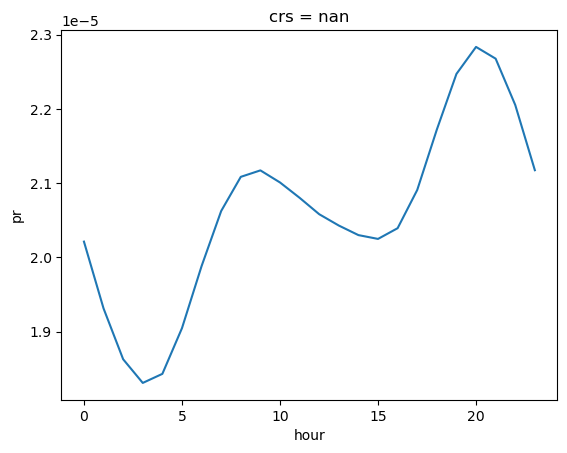

In [3]:
land_mean.plot()

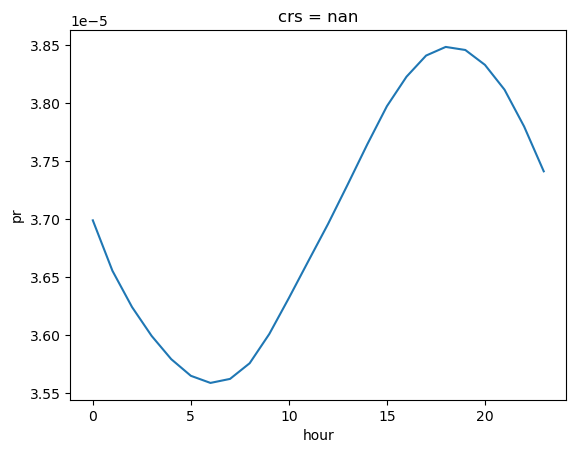

In [5]:
ocean_mean.plot()

In [4]:
land_mean

<xarray.DataArray 'pr' (hour: 24)> Size: 96B
dask.array<mean_agg-aggregate, shape=(24,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
    crs      float64 8B ...
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23

# **for 2020 Apr-Sep**

In [34]:
# List of NetCDF files
file_list = [
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200401-20200430.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200501-20200531.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200601-20200630.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200701-20200731.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200801-20200831.nc",
    "/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20200901-20200930.nc"
]

# Open and concatenate along 'time' dimension for a specific variable
# Replace 'your_variable_name' with the actual variable name
# ds = xr.open_mfdataset(
#     file_list,
#     combine='by_coords'  # or 'nested' with concat_dim='time' if not auto-aligning
# )
ds = xr.open_mfdataset(
    file_list,
    combine='by_coords',
    chunks={'time': 1000}  # or a specific value like 1000, depending on your dataset
)

# ds = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/mtpr/2020/mtpr_era5_oper_sfc_20201201-20201231.nc", chunks={'time': 24})
pr = ds['mtpr']
hourly_avg = pr.groupby('time.hour').mean(dim='time')

pr_max = xr.Dataset({
    "max_hour": hourly_avg.idxmax(dim='hour'),
    "max_value": hourly_avg.max(dim='hour'),
    "min_hour": hourly_avg.idxmin(dim='hour'),
    "min_value": hourly_avg.min(dim='hour'),
})

# Add difference between max and min values
pr_max["value_range"] = pr_max["max_value"] - pr_max["min_value"]


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


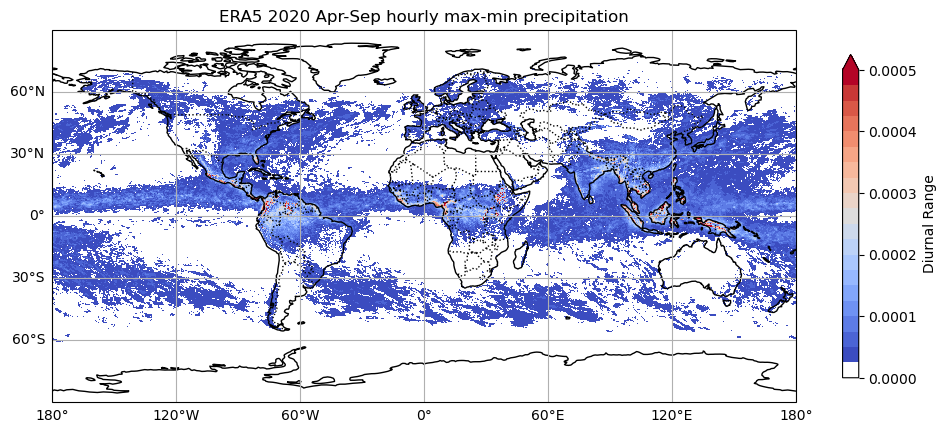

In [20]:
# plt.figure(figsize=(10, 5))
# pr_max["value_range"].plot(cmap='viridis')
# plt.title('Value Range')
# plt.show()
base_cmap = plt.get_cmap('coolwarm')

# Get the colors from the base colormap
colors = base_cmap(np.linspace(0, 1, 19))

# Prepend white to the list of colors
new_colors = np.vstack(([1, 1, 1, 1], colors))  # white with alpha=1

# Create new colormap
new_cmap = mcolors.ListedColormap(new_colors)

plt.figure(figsize=(12, 6))
proj = ccrs.PlateCarree(central_longitude=0.0)
ax = plt.axes(projection=proj)

# Plot the data (transform tells Cartopy what the data's native projection is)
pr_max["value_range"].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=new_cmap, vmin=0, vmax=0.0005,
    cbar_kwargs={'label': 'Diurnal Range', 'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 2020 Apr-Sep hourly max-min precipitation')

plt.show()

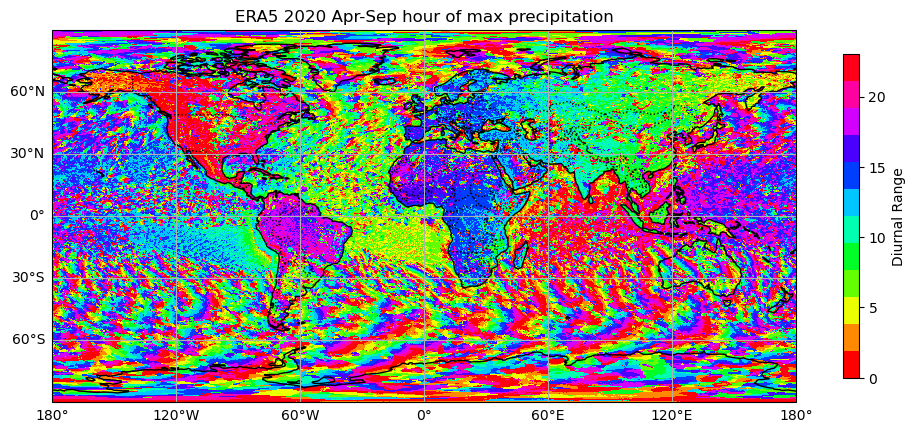

In [21]:
# plt.figure(figsize=(10, 5))
# pr_max["value_range"].plot(cmap='viridis')
# plt.title('Value Range')
# plt.show()
cmap = plt.get_cmap('hsv', 12)

plt.figure(figsize=(12, 6))
proj = ccrs.PlateCarree(central_longitude=0.0)
ax = plt.axes(projection=proj)

# Plot the data (transform tells Cartopy what the data's native projection is)
pr_max["max_hour"].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=cmap, vmin=0, vmax=23,
    cbar_kwargs={'label': 'Diurnal Range', 'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 2020 Apr-Sep hour of max precipitation')

plt.show()

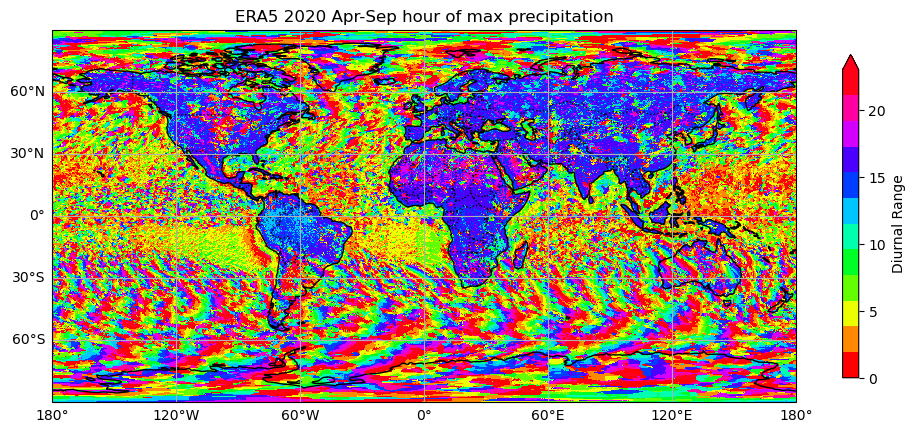

In [43]:
# plt.figure(figsize=(10, 5))
# pr_max["value_range"].plot(cmap='viridis')
# plt.title('Value Range')
# plt.show()
cmap = plt.get_cmap('hsv', 12)

plt.figure(figsize=(12, 6))
proj = ccrs.PlateCarree(central_longitude=0.0)
ax = plt.axes(projection=proj)

# Plot the data (transform tells Cartopy what the data's native projection is)
local_hour.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # the data is in PlateCarree (regular lat/lon)
    cmap=cmap, vmin=0, vmax=23,
    cbar_kwargs={'label': 'Diurnal Range', 'shrink': 0.7}
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('ERA5 2020 Apr-Sep hour of max precipitation')

plt.show()

# **UM pr**

In [3]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z9.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
ds_1.sftlf

<xarray.DataArray 'sftlf' (cell: 3145728)> Size: 25MB
dask.array<open_dataset-sftlf, shape=(3145728,), dtype=float64, chunksize=(98304,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs      float64 8B ...
Attributes:
    STASH:          [1, 0, 30]
    coarsened:      False
    grid_mapping:   healpix_nested
    healpix_zoom:   10
    long_name:      land_area_fraction
    regrid_method:  easygems_delaunay
    source:         Data from Met Office Unified Model
    standard_name:  land_binary_mask
    um_version:     13.5

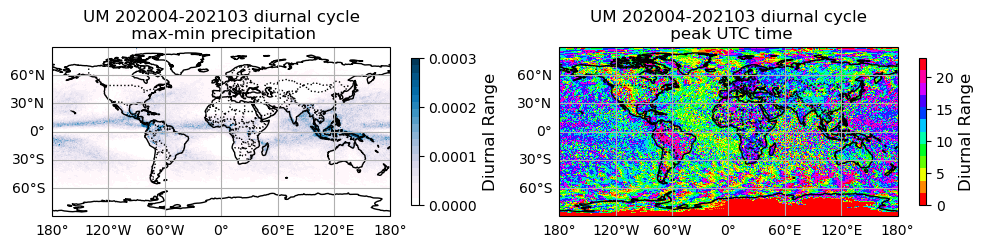

In [21]:
ds = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/um_prmax.nc")

da_max = ds["value_range"]
# plt.figure(figsize=(10, 5))
# pr_max["value_range"].plot(cmap='viridis')
# plt.title('Value Range')
# plt.show()

# cmap = get_cmap('coolwarm', 9)  # use a colormap with discrete colors
# cmap = plt.colormaps.get_cmap('coolwarm', 9)
# base_cmap = plt.colormaps.get_cmap('coolwarm', 9)
base_cmap = plt.get_cmap('PuBu')

# Get the colors from the base colormap
colors = base_cmap(np.linspace(0, 1, 19))

# Prepend white to the list of colors
new_colors = np.vstack(([1, 1, 1, 1], colors))  # white with alpha=1

# Create new colormap
new_cmap = mcolors.ListedColormap(new_colors)


fig = plt.figure(figsize=(12, 6))
proj = ccrs.PlateCarree(central_longitude=0.0)
# ax = plt.axes(projection=proj)

ax=fig.add_subplot(2,2,1,projection=proj)
ax.set_global()
# ax = egh.create_geoaxis(add_coastlines=True,projection=proj)
im = egh.healpix_show(da_max.values, ax=ax, cmap=new_cmap, vmin=0, vmax=0.0003, add_coastlines=True)
# fig=ax.get_figure()
cbar = fig.colorbar(im, orientation='vertical', shrink=0.7)
cbar.set_label('Diurnal Range', fontsize=12)
# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('UM 202004-202103 diurnal cycle\n max-min precipitation')


ax=fig.add_subplot(2,2,2,projection=proj)
ax.set_global()
# plt.figure(figsize=(10, 5))
# pr_max["value_range"].plot(cmap='viridis')
# plt.title('Value Range')
# plt.show()
cmap_2 = plt.get_cmap('hsv', 12)

# # Compute the time offset in hours based on longitude
# lon = ds["max_hour"].longitude
# time_offset = lon / 15.0  # degrees per hour

# # Broadcast time offset to the shape of max_hour
# offset_2d = xr.broadcast(time_offset, pr_max["max_hour"])[0]

# # Convert UTC to local time
# local_hour = (ds["max_hour"] + offset_2d) % 24
# local_hour.name = "local_hour"


# ax = egh.create_geoaxis(fig=ax, add_coastlines=True,projection=proj)
im_2 = egh.healpix_show(ds["max_hour"].values, ax=ax, cmap=cmap_2, vmin=0, vmax=23, add_coastlines=True)
# fig=ax.get_figure()
cbar = fig.colorbar(im_2, orientation='vertical', shrink=0.7)
cbar.set_label('Diurnal Range', fontsize=12)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title('UM 202004-202103 diurnal cycle\n peak UTC time') # local

plt.show()

# **for 2020 Apr-Sep**

In [30]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
pr_selected = ds_1.pr.sel(time=slice('2020-04-01', '2020-09-30'))
# Group by the hour of the day and compute the mean
hourly_avg = pr_selected.groupby('time.hour').mean(dim='time')

pr_max = xr.Dataset({
    "max_hour": hourly_avg.idxmax(dim='hour'),
    "max_value": hourly_avg.max(dim='hour'),
    "min_hour": hourly_avg.idxmin(dim='hour'),
    "min_value": hourly_avg.min(dim='hour'),
})

# Add difference between max and min values
pr_max["value_range"] = pr_max["max_value"] - pr_max["min_value"]
# ds_dict_diff = {3:pr_max.value_range, 4:pr_max_2.value_range}

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: bitmask sparsity=0.6654545454545454, merge=False, choosing 'map-reduce'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


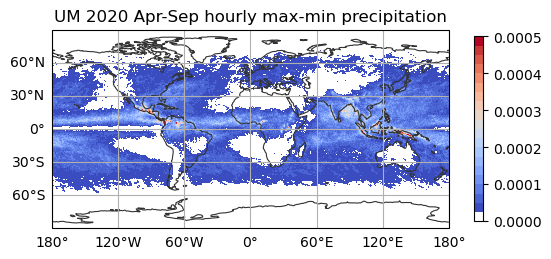

In [31]:
# Define a custom colormap and normalization
base_cmap = plt.get_cmap('coolwarm')

# Get the colors from the base colormap
colors = base_cmap(np.linspace(0, 1, 19))

# Prepend white to the list of colors
new_colors = np.vstack(([1, 1, 1, 1], colors))  # white with alpha=1

# Create new colormap
new_cmap = mcolors.ListedColormap(new_colors)

# Plotting lat/lon values over the grid
projection=ccrs.PlateCarree(central_longitude=0.0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(pr_max.value_range.values, ax=ax, cmap=new_cmap, vmin=0, vmax=0.0005, add_coastlines=True)
ax.set_title(f'UM 2020 Apr-Sep hourly max-min precipitation')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
fig=ax.get_figure()
fig.colorbar(im,orientation='vertical', shrink=0.5) # horizontal , aspect=30, pad=0.05

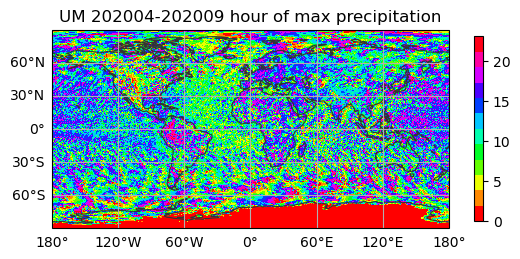

In [17]:
# Define a custom colormap and normalization
# cmap = cm.coolwarm
cmap = plt.get_cmap('hsv', 12)

# Plotting lat/lon values over the grid
projection=ccrs.PlateCarree(central_longitude=0.0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(pr_max.max_hour.values, ax=ax, cmap=cmap, vmin=0, vmax=23, add_coastlines=True)
ax.set_title(f'UM 202004-202009 hour of max precipitation')
# ax.gridlines(draw_labels=True)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
fig=ax.get_figure()
fig.colorbar(im,orientation='vertical', shrink=0.5) #, aspect=30, pad=0.05

In [7]:
data_2d_z1 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_1 = xr.open_zarr(data_2d_z1)
pr_selected = ds_1.pr.sel(time=slice('2020-04-01', '2021-03-31'))
hourly_avg = pr.groupby('time.month').apply(lambda x: x.groupby('time.hour').mean(dim='time'))
hourly_avg

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None

<xarray.DataArray 'mtpr' (month: 12, latitude: 721, longitude: 1440, hour: 24)> Size: 2GB
dask.array<transpose, shape=(12, 721, 1440, 24), dtype=float64, chunksize=(1, 91, 180, 24), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * hour       (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      kg m**-2 s**-1
    long_name:  Mean total precipitation rate

In [ ]:
# Step 1: Select month == 1 (January)
mtpr_january = mtpr.sel(month=1)

# Step 2: Find the hour of maximum precipitation at each lat/lon
hour_of_max = mtpr_january.argmax(dim='hour')


In [ ]:
hourly_avg = pr.groupby('time.month').apply(lambda x: x.groupby('time.hour').mean(dim='time'))

pr_max = xr.Dataset({
    "max_hour": hourly_avg.idxmax(dim='hour'),
    "max_value": hourly_avg.max(dim='hour'),
    "min_hour": hourly_avg.idxmin(dim='hour'),
    "min_value": hourly_avg.min(dim='hour'),
})

# Add difference between max and min values
pr_max["value_range"] = pr_max["max_value"] - pr_max["min_value"]
